<a href="https://colab.research.google.com/github/Nayal17/Time_Series_Analysis_And_Forecasting-/blob/main/Handling_missing_values_in_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!unzip "/content/drive/MyDrive/Air Quality[2015-2020]/archive.zip"

Archive:  /content/drive/MyDrive/Air Quality[2015-2020]/archive.zip
  inflating: city_day.csv            
  inflating: city_hour.csv           
  inflating: station_day.csv         
  inflating: station_hour.csv        
  inflating: stations.csv            


In [1]:
!pip install --upgrade "kaleido==0.1.*"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 74.6 MB 1.2 MB/s 


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [13]:
city_day = pd.read_csv("/content/city_day.csv")
print(city_day.shape[0]);city_day.head()

29531


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


There are 4598 missing values in PM2.5 column. We can not drop values in time series data as it is sequential.

In [14]:
city_day = city_day.sort_values(by=['Date'])
city_day['Date'] = pd.to_datetime(city_day['Date'])
city_day = city_day.set_index("Date")
city_day["PM2.5"].isnull().sum()

4598

We can visualize the null values in the below non-continous graph.

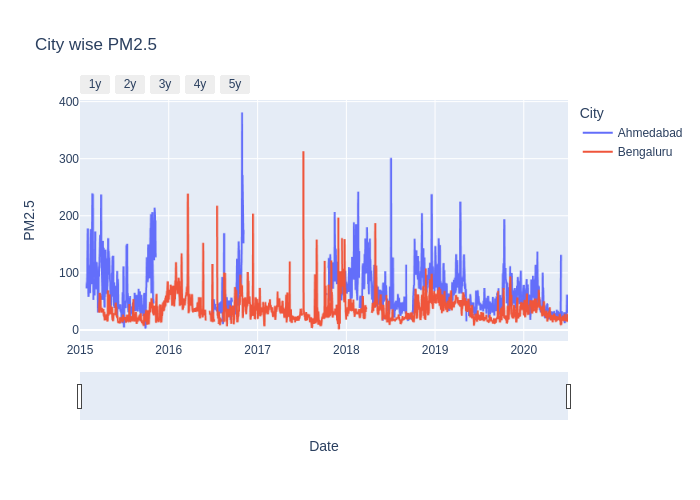

In [15]:
city_day_ban_ahm = city_day[(city_day['City']=='Ahmedabad') | (city_day['City']=='Bengaluru')]
fig = px.line(city_day_ban_ahm,x=city_day_ban_ahm.index, y="PM2.5", title="City wise PM2.5", color="City")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=[
            dict(count=1,label="1y",step="year",stepmode="backward"),
            dict(count=2,label="2y",step="year",stepmode="backward"),
            dict(count=3,label="3y",step="year",stepmode="backward"),
            dict(count=4,label="4y",step="year",stepmode="backward"),
            dict(count=5,label="5y",step="year",stepmode="backward"),

        ]
    )
)
fig.show("png")

Filling NaN values with forward_fill( **ffill** ) and backward_fill( **bfill** ) method. As we can see below, if the first value of column is NaN so ffill will not work and same with backword fill if next value itself is NaN.

Initially null values for PM2.5 were 4598 and now reduced to 27 using forward fill and those 27 values are the first 27 values of the dataset.

In [16]:
city_day_ahm = city_day[(city_day['City']=='Ahmedabad')]

for_fill = city_day_ahm[['PM2.5']].copy()
for_fill["ffill_PM2.5"] = for_fill["PM2.5"].fillna(method="ffill") # bfill for backward fill
for_fill.loc["2015-02-24":"2015-02-28"]

,PM2.5,ffill_PM2.5
Date,,
2015-02-24,118.72,118.72
2015-02-25,52.99,52.99
2015-02-26,NaN,52.99
2015-02-27,NaN,52.99
2015-02-28,NaN,52.99


Taking **mean** of xn,xn-1,xn-2,.... to fill xn, where n+1 is the window size

In [17]:
roll_fill = city_day_ahm[['PM2.5']].copy()
roll_fill["roll_fill_PM2.5"] = roll_fill["PM2.5"].rolling(window=2, min_periods=1).mean() 
roll_fill.loc["2015-02-22":"2015-02-28"]

,PM2.5,roll_fill_PM2.5
Date,,
2015-02-22,142.96,191.460
2015-02-23,238.41,190.685
2015-02-24,118.72,178.565
2015-02-25,52.99,85.855
2015-02-26,NaN,52.990
2015-02-27,NaN,NaN
2015-02-28,NaN,NaN


Using previous year data to fill up null values as there is year wise seasonality

In [18]:
city_day_ahm = city_day_ahm.reset_index()

***NOTE***: np.nan==np.nan -> False . Hence we set all nan values to -999 for easy execution

In [19]:
def func(x):
  if x["PM2.5"]==-999:
    x["fill_prev"] = city_day_ahm[city_day_ahm["Date"]==(x.Date-pd.tseries.offsets.DateOffset(years=1))]["PM2.5"].values[0]
    return x
  else: 
    x["fill_prev"] = x["PM2.5"]
    return x


city_day_ahm['PM2.5'] = city_day_ahm['PM2.5'].fillna(-999) # fill nan with -999

city_ahm_16_20 = city_day_ahm[(city_day_ahm['Date']>="2016")&(city_day_ahm['Date']<="2020")] # cannot fill prev year data for 2015 as there is no data for 2014

fill_prev = city_ahm_16_20[['Date','PM2.5']].copy()
fill_prev.reset_index(drop=True,inplace=True)
fill_prev['PM2.5'] = fill_prev['PM2.5'].fillna(-999) # fill nan with -999

fill_prev["fill_prev"] = -1
fill_prev = fill_prev.apply(func, axis=1)

Values which are not nan in previous year pm2.5 are filled here

In [20]:
display(fill_prev[25:30])
print("\nAbove nan values are filled from below given values\n")
display(city_day_ahm[(city_day_ahm['Date']>="2015-01-26")&(city_day_ahm['Date']<"2015-01-30")][["Date","PM2.5"]])

,Date,PM2.5,fill_prev
25,2016-01-26,-999.0,-999.00
26,2016-01-27,-999.0,-999.00
27,2016-01-28,-999.0,73.24
28,2016-01-29,-999.0,83.13
29,2016-01-30,-999.0,79.84



Above nan values are filled from below given values



,Date,PM2.5
25,2015-01-26,-999.00
26,2015-01-27,-999.00
27,2015-01-28,73.24
28,2015-01-29,83.13


In [21]:
()

()